In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import joblib

In [3]:
def read_data(file_path):
    data = pd.read_csv(file_path)
    return data

data = read_data('./ai4i2020.csv')
print(data.iloc[:5, :]) 
print(data.shape)

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [4]:
data.dtypes.value_counts()

int64      9
float64    3
object     2
Name: count, dtype: int64

In [5]:
# 前两列是编号，中间6列是特征，最后5列是目标
data = data.iloc[:, 2:]
print(data.iloc[:5, :]) 

  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  
0         42.8                0                0    0    0    0    0    0  
1         46.3                3                0    0    0    0    0    0  
2         49.4                5                0    0    0    0    0    0  
3         39.5                7                0    0    0    0    0    0  
4         40.0                9                0    0    0    0    0    0  


In [6]:
sum(data["Machine failure"])

339

In [7]:
class pt_feature():
    def __init__(self, data, axes_shape:tuple[int, int]=(3, 2), figsize:tuple[int, int]=(15, 8)):
        self.data = data
        self.i = 0
        self.j = 0
        self.fig, self.axes = plt.subplots(*axes_shape, figsize=figsize) 

    def plot_feature(self, feature_name):
        i = self.i
        j = self.j
        ax = self.axes[i, j]
        
        x = self.data[feature_name].to_numpy()
        ax.hist(x, bins=30, alpha=0.7, density=True, color='blue', edgecolor='black', zorder=1, label=feature_name)
        
        mu, std = norm.fit(x)
        x_fit = np.linspace(x.min(), x.max(), 1000)
        p = norm.pdf(x_fit, mu, std)
        ax.plot(x_fit, p, linewidth=2, zorder=2, color='red', label=f'Fit: $\\mu$={mu:.2f}, $\\sigma$={std:.2f}')
        
        ax.grid(True, alpha=0.6, linestyle='--', linewidth=0.6)
        ax.set_title(feature_name)
        ax.legend()
        self.fig.tight_layout()
        if self.j == self.axes.shape[1] - 1:
            self.j = 0
            self.i += 1
        else:
            self.j += 1
        

In [8]:
print(data.dtypes[1:5].index)
ns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]'],
      dtype='object')


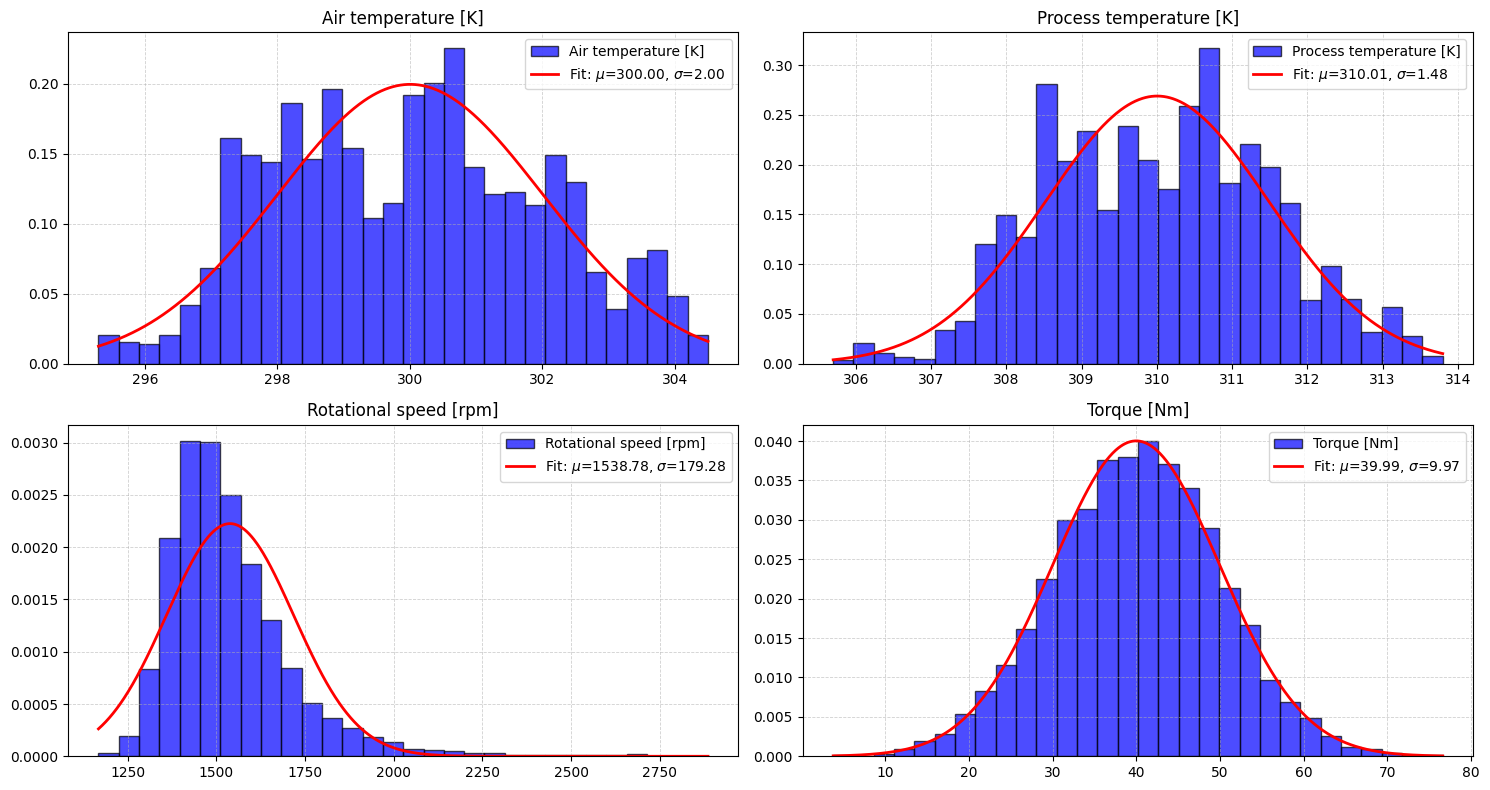

In [9]:
pt = pt_feature(data, axes_shape=(2, 2))
for col in ns:
    pt.plot_feature(col)

Text(0.5, 1.0, 'Tool wear [min]')

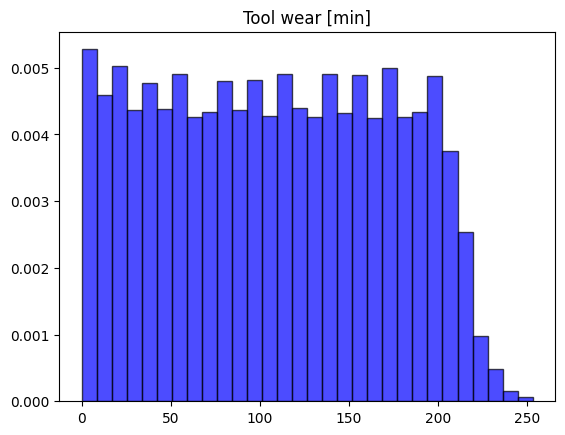

In [10]:
plt.hist(data["Tool wear [min]"].to_numpy(), bins=30, alpha=0.7, density=True, color='blue', edgecolor='black', zorder=1)
plt.title("Tool wear [min]")

In [11]:
def numeric(x):
    return (x - x.mean()) / (x.std())

def uniform(x):
    return (x - x.min()) / (x.max() - x.min())

data[ns] = numeric(data[ns])
data["Tool wear [min]"] = uniform(data["Tool wear [min]"])
data.head()


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,-0.952342,-0.947313,0.068182,0.282186,0.000000,0,0,0,0,0,0
1,L,-0.902348,-0.879915,-0.729435,0.633276,0.011858,0,0,0,0,0,0
2,L,-0.952342,-1.014710,-0.227438,0.944242,0.019763,0,0,0,0,0,0
3,L,-0.902348,-0.947313,-0.589992,-0.048843,0.027668,0,0,0,0,0,0
4,L,-0.902348,-0.879915,-0.729435,0.001313,0.035573,0,0,0,0,0,0


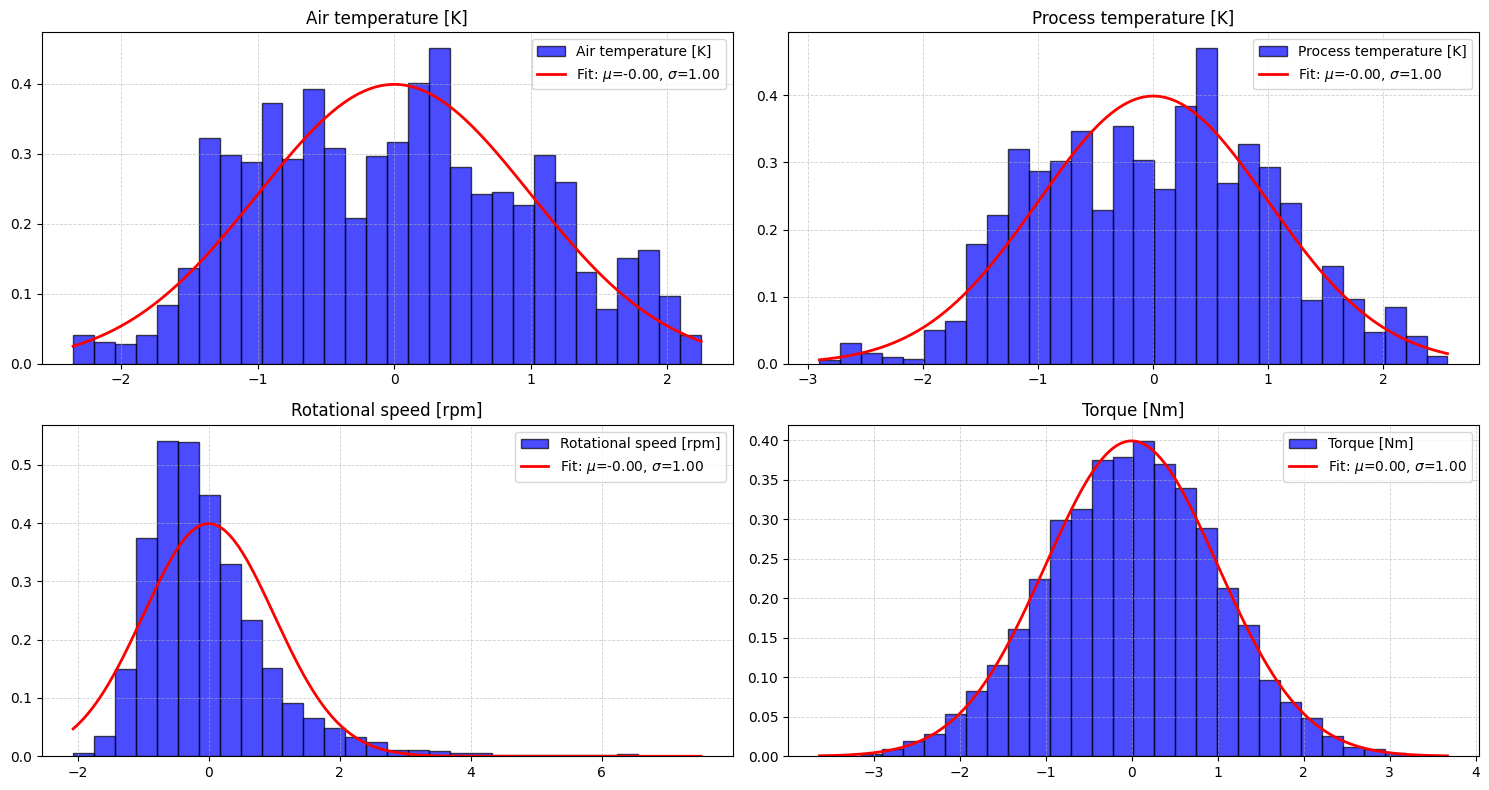

In [12]:
pt = pt_feature(data, axes_shape=(2, 2))
for col in ns:
    pt.plot_feature(col)

Text(0.5, 1.0, 'Tool wear [min]')

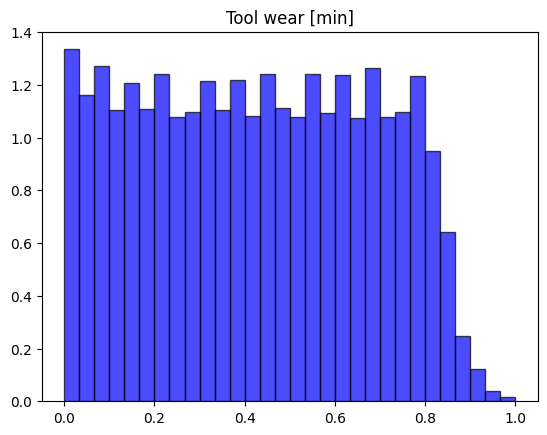

In [13]:
plt.hist(data["Tool wear [min]"].to_numpy(), bins=30, alpha=0.7, density=True, color='blue', edgecolor='black', zorder=1)
plt.title("Tool wear [min]")

In [14]:
data = pd.get_dummies(data)
data.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,-0.952342,-0.947313,0.068182,0.282186,0.000000,0,0,0,0,0,0,False,False,True
1,-0.902348,-0.879915,-0.729435,0.633276,0.011858,0,0,0,0,0,0,False,True,False
2,-0.952342,-1.014710,-0.227438,0.944242,0.019763,0,0,0,0,0,0,False,True,False
3,-0.902348,-0.947313,-0.589992,-0.048843,0.027668,0,0,0,0,0,0,False,True,False
4,-0.902348,-0.879915,-0.729435,0.001313,0.035573,0,0,0,0,0,0,False,True,False


In [15]:
features = data.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
#labels = data[["TWF", 'HDF', 'PWF', 'OSF', 'RNF']]
labels = data['Machine failure']

features = features.astype(np.float64)
labels = labels.astype(np.float64)  

print(features.head())
print(labels.head())

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0            -0.952342                -0.947313                0.068182   
1            -0.902348                -0.879915               -0.729435   
2            -0.952342                -1.014710               -0.227438   
3            -0.902348                -0.947313               -0.589992   
4            -0.902348                -0.879915               -0.729435   

   Torque [Nm]  Tool wear [min]  Type_H  Type_L  Type_M  
0     0.282186         0.000000     0.0     0.0     1.0  
1     0.633276         0.011858     0.0     1.0     0.0  
2     0.944242         0.019763     0.0     1.0     0.0  
3    -0.048843         0.027668     0.0     1.0     0.0  
4     0.001313         0.035573     0.0     1.0     0.0  
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Machine failure, dtype: float64


In [16]:
with open("fresh.csv", "w") as f:
    f.write(data.astype(np.float64).to_csv(index=False))

## 不平衡学习

In [17]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.5, stratify=labels, random_state= 42)


In [18]:
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced'
)

model.fit(train_features, train_labels)

y_pred = model.predict(test_features)
y_prob = model.predict_proba(test_features)[:, 1]

print("Accuracy:", accuracy_score(test_labels, y_pred))
print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
print("Report:\n", classification_report(test_labels, y_pred))

Accuracy: 0.8304
Confusion Matrix:
 [[4015  816]
 [  32  137]]
Report:
               precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      4831
         1.0       0.14      0.81      0.24       169

    accuracy                           0.83      5000
   macro avg       0.57      0.82      0.57      5000
weighted avg       0.96      0.83      0.88      5000



Text(0.5, 1.0, 'Precision-Recall Curve')

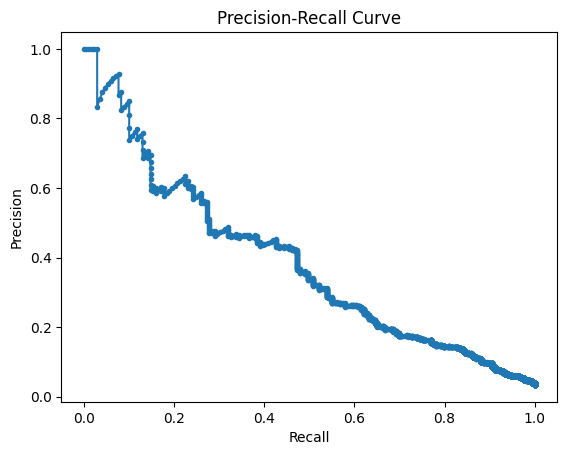

In [19]:
precision, recall, thresholds = precision_recall_curve(test_labels, y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')


In [20]:
print(model.coef_)      # 权重 w
print(model.intercept_) # 偏置 b

[[ 2.03118095 -1.472953    1.7134676   2.40677126  3.33382725  0.03152097
   0.12424977 -0.15759802]]
[-3.02396222]


In [21]:

clf = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=5,
    random_state=42,
    min_samples_leaf=10,
)

clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
y_prob = clf.predict_proba(test_features)[:, 1]

print(confusion_matrix(test_labels, y_pred))
print(classification_report(test_labels, y_pred))

[[4493  338]
 [  24  145]]
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      4831
         1.0       0.30      0.86      0.44       169

    accuracy                           0.93      5000
   macro avg       0.65      0.89      0.70      5000
weighted avg       0.97      0.93      0.94      5000



Text(0.5, 1.0, 'Precision-Recall Curve')

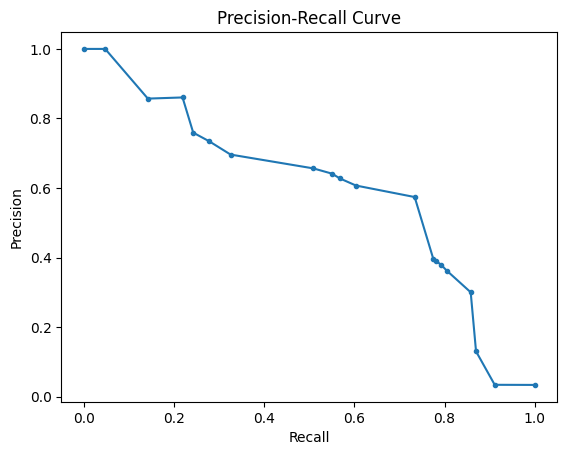

In [22]:

precision, recall, thresholds = precision_recall_curve(test_labels, y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')


## 小样本学习

In [23]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.99, stratify=labels, random_state= 42)

[[9558    6]
 [ 327    9]]
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      9564
         1.0       0.60      0.03      0.05       336

    accuracy                           0.97      9900
   macro avg       0.78      0.51      0.52      9900
weighted avg       0.95      0.97      0.95      9900



Text(0.5, 1.0, 'Precision-Recall Curve')

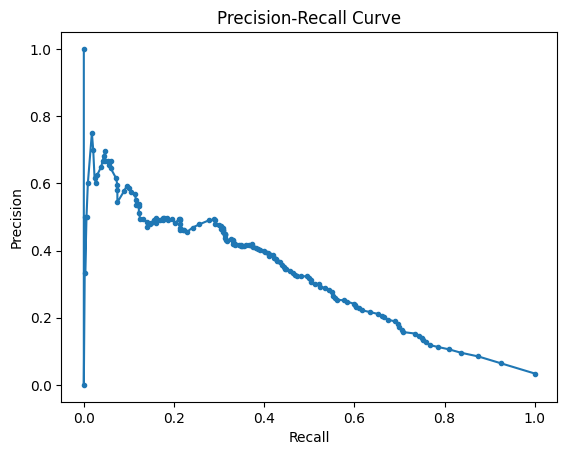

In [24]:

rf = RandomForestClassifier(
        n_estimators=300,
        class_weight={0:1, 1:3},
        random_state=42
    )

rf.fit(train_features, train_labels)
y_pred = rf.predict(test_features)
y_prob = rf.predict_proba(test_features)[:, 1]

print(confusion_matrix(test_labels, y_pred))
print(classification_report(test_labels, y_pred))


precision, recall, thresholds = precision_recall_curve(test_labels, y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

In [25]:

model = LogisticRegression(
    class_weight={0:1, 1:3},
    max_iter=1000
)
model.fit(train_features, train_labels)

y_prob = model.predict_proba(test_features)[:, 1]
y_pred = (y_prob > 0.3).astype(int)


print("Accuracy:", accuracy_score(test_labels, y_pred))
print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
print("Report:\n", classification_report(test_labels, y_pred))

Accuracy: 0.9421212121212121
Confusion Matrix:
 [[9166  398]
 [ 175  161]]
Report:
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      9564
         1.0       0.29      0.48      0.36       336

    accuracy                           0.94      9900
   macro avg       0.63      0.72      0.66      9900
weighted avg       0.96      0.94      0.95      9900



In [26]:
lr = LogisticRegression(
        class_weight={0:1, 1:4},
        max_iter=1000
    )

svm = SVC(
        kernel='rbf',
        class_weight={0:1, 1:4},
        probability=True
    )

rf = RandomForestClassifier(
        n_estimators=300,
        class_weight={0:1, 1:3},
        random_state=42
    )



voting = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('svm', svm),
        ('rf', rf)
    ],
    voting='soft',
    weights=[0.45, 0.35, 0.2]
)

voting.fit(train_features, train_labels)

y_prob = voting.predict_proba(test_features)[:, 1]
y_pred = (y_prob > 0.30).astype(int)


print("Accuracy:", accuracy_score(test_labels, y_pred))
print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
print("Report:\n", classification_report(test_labels, y_pred))

Accuracy: 0.9587878787878787
Confusion Matrix:
 [[9354  210]
 [ 198  138]]
Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      9564
         1.0       0.40      0.41      0.40       336

    accuracy                           0.96      9900
   macro avg       0.69      0.69      0.69      9900
weighted avg       0.96      0.96      0.96      9900



In [27]:

precision, recall, thresholds = precision_recall_curve(test_labels, y_prob)
f1 = 2 * precision * recall / (precision + recall + 1e-9)

best_idx = np.argmax(f1)
best_th = thresholds[best_idx]

print(best_th, precision[best_idx], recall[best_idx], f1[best_idx])


0.31778982285374313 0.41641337386018235 0.40773809523809523 0.41203007468802527


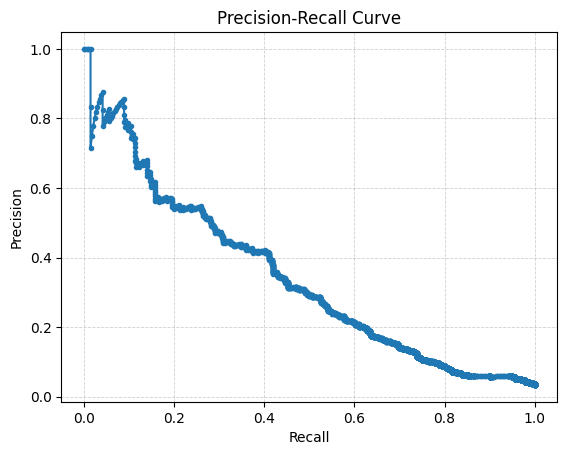

In [28]:

precision, recall, thresholds = precision_recall_curve(test_labels, y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.6, linestyle='--', linewidth=0.6)


In [29]:

joblib.dump(voting, 'voting_model.joblib')


['voting_model.joblib']